# Monte Carlo Methods

In [4]:
import gym
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```

In [5]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Play Blackjack with a random policy.  

In [6]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(18, 10, False)
End game! Reward:  -1
You lost :(

(16, 10, False)
End game! Reward:  -1
You lost :(

(12, 10, False)
(18, 10, False)
(20, 10, False)
End game! Reward:  -1
You lost :(



### MC Prediction: State Values
Investigate a policy where the player always sticks if the sum of her cards exceeds 18.  The function `generate_episode_from_limit` samples an episode using this policy. 

**input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

**output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [7]:
def generate_episode_from_limit(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        action = 0 if state[0] > 18 else 1
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [8]:
for i in range(3):
    print(generate_episode_from_limit(env))

[((17, 9, False), 1, -1)]
[((12, 3, False), 1, 0), ((13, 3, False), 1, 0), ((20, 3, False), 0, -1.0)]
[((14, 3, False), 1, 0), ((19, 3, False), 0, 1.0)]


First-visit or every-visit MC prediction.

Arguments:
- `env`: An instance of an OpenAI Gym environment.
- `num_episodes`: The number of episodes that are generated through agent-environment interaction.
- `generate_episode`: Returns an episode of interaction.
- `gamma`: The discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

Returns as output:
- `V`: Dictionary where `V[s]` is the estimated value of state `s`.

In [9]:
from collections import defaultdict
from statistics import mean
import numpy as np
import sys

def mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionary of lists
    returns = defaultdict(list)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        #monte carlo technique
        episode = generate_episode(env)
        s, a, r = zip(*episode)
        discounts = [gamma ** i for i in range(len(r) + 1)]
        for i, state in enumerate(s):
            returns[state].append(sum([reward * discount for reward, discount in zip(r[i:], discounts[: -(i + 1)])]))

    V = {k: mean(v) for k, v in returns.items()}
        
    return V

Visualize the result.

Episode 500000/500000.

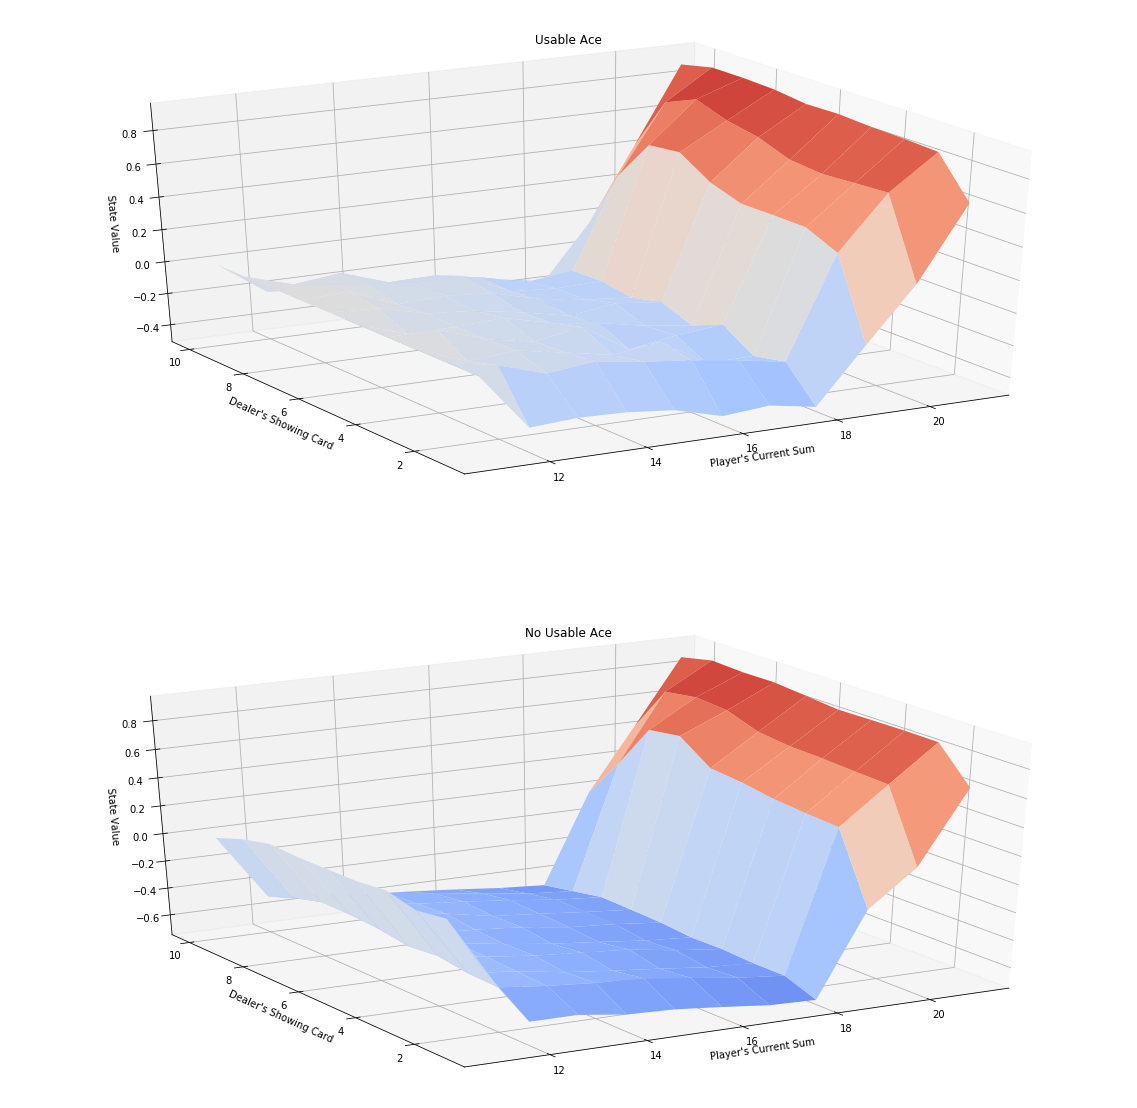

In [10]:
from plot_utils import plot_blackjack_values
%matplotlib inline

# obtain the value function
V = mc_prediction_v(env, 500000, generate_episode_from_limit)

# plot the value function
plot_blackjack_values(V)

### MC Prediction: Action Values

Action `STICK` is selected with 80% probability if the sum is greater than 18. If the sum is 18 or below, select action `HIT` with 80% probability.

In [11]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [22]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        #monte carlo technique
        episode = generate_episode(env)
        s, a, r = zip(*episode)
        discounts = [gamma ** i for i in range(len(r) + 1)]

        for i, state in enumerate(s):
            returns_sum[state][a[i]] += sum([rew * disc for rew, disc in zip(r[i:], discounts[: -(i + 1)])])
            N[state][a[i]] += 1.
            Q[state][a[i]] = returns_sum[state][a[i]] / N[state][a[i]]
    
    return Q

Episode 500000/500000.

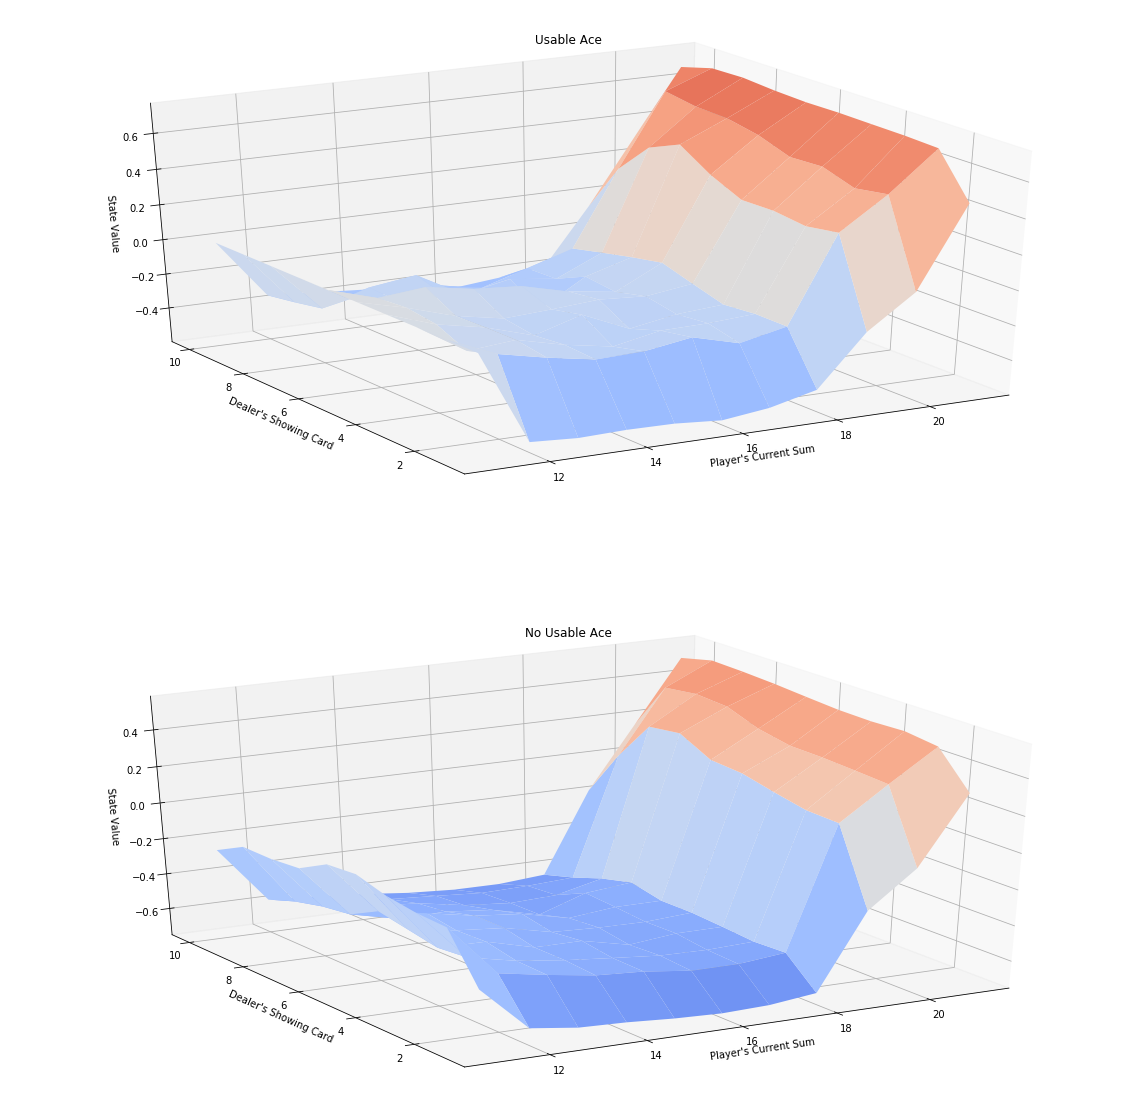

In [13]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### MC Control: GLIE

Implementation of constant-$\alpha$ MC control.  

In [23]:
from collections import Counter

def generate_glie_episode(env, eps, Q, nA):
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p = get_probs(eps, Q[state], nA))
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    
    return episode
                

def get_probs(eps, Q_s, nA):
    policy_prob = []
    inv_eps = 1 - eps
    equiprob = 1 / nA
    
    count = Counter(Q_s)
    max_s_a = max(Q_s)
    probs = [equiprob if count[action] == nA\
                       else inv_eps / count[action] if action == max_s_a\
                       else eps / (nA - count[max_s_a])\
                       for action in Q_s]
        
    return probs

def update_action_value(episode, Q, N, gamma):
    s, a, r = zip(*episode)
    discounts = [gamma ** i for i in range(len(r) + 1)]
    returns_sum = 0

    for i, state in enumerate(s):
        old_Q = Q[state][a[i]]
        old_N = N[state][a[i]]
        
        returns_sum = sum([rew * disc for rew, disc in zip(r[i:], discounts[: -(i + 1)])])
        
        Q[state][a[i]] = old_Q + (returns_sum - old_Q) / (old_N + 1)
        N[state][a[i]] += 1
    
    return Q, N

def mc_control_GLIE(env, num_episodes, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        #monte carlo technique
        eps = 1 / (i_episode * 1.5)
        
        episode = generate_glie_episode(env, eps, Q, nA)

        Q, N = update_action_value(episode, Q, N, gamma)
    
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

In [15]:
# obtain the estimated optimal policy and action-value function
policy_glie, Q_glie = mc_control_GLIE(env, 500000)

Episode 500000/500000.

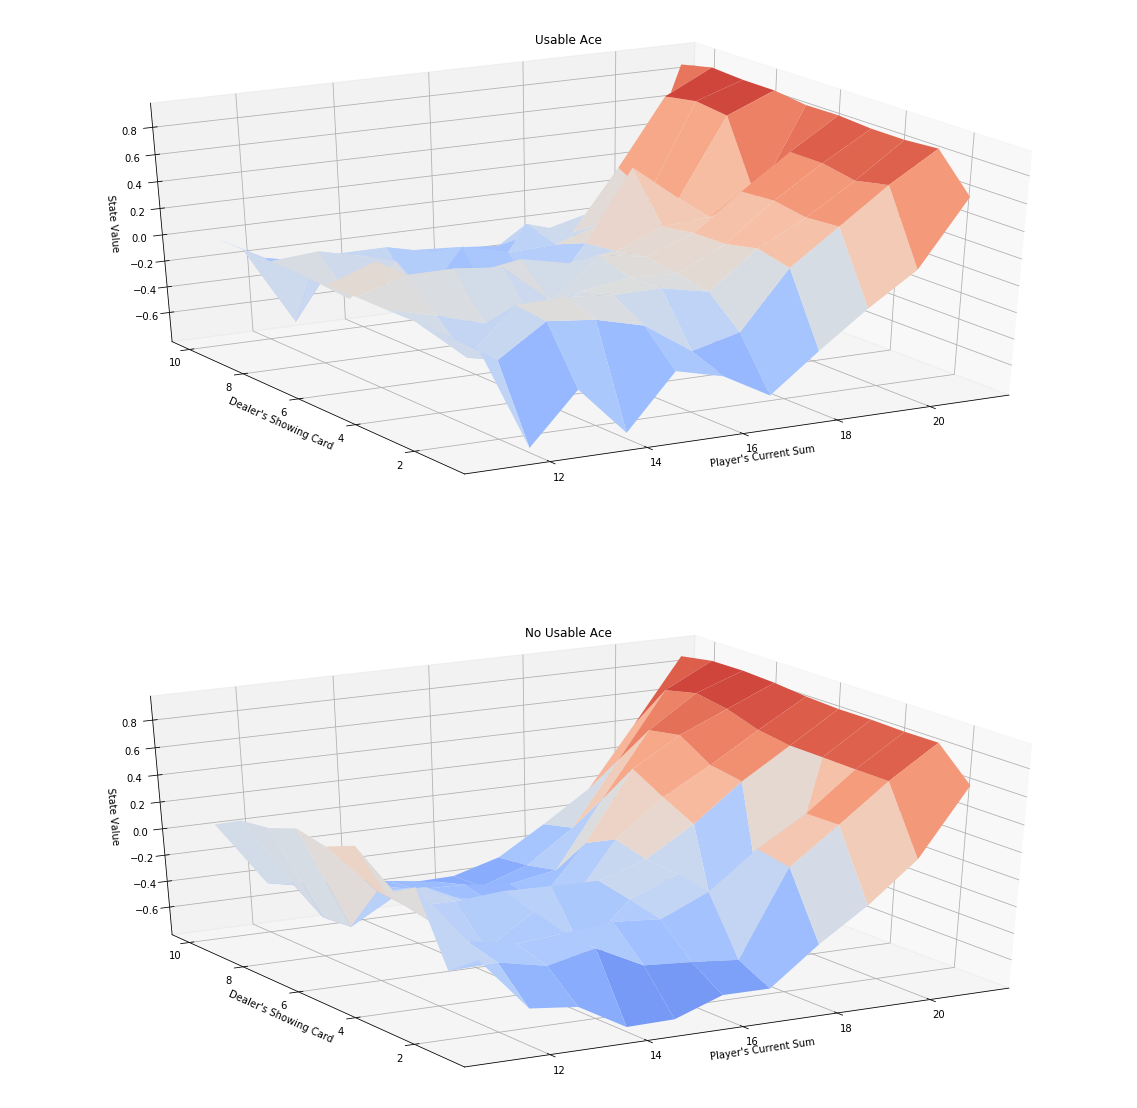

In [16]:
# obtain the state-value function
V_glie = dict((k,np.max(v)) for k, v in Q_glie.items())

# plot the state-value function
plot_blackjack_values(V_glie)

Visualize the policy that is estimated to be optimal.

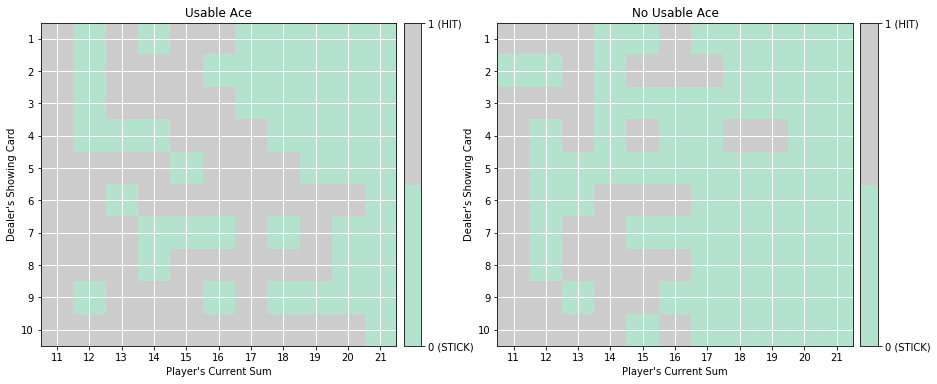

In [17]:
from plot_utils import plot_policy

# plot the policy
plot_policy(policy_glie)

The **true** optimal policy $\pi_*$ can be found on page 82 of **'Reinforcement Learning' by Sutton and Brato**:

![True Optimal Policy](images/optimal.png)

### MC Control: Constant-$\alpha$

Constant-$\alpha$ MC control.

In [18]:
from collections import Counter

def update_action_value_alpha(alpha, episode, Q, gamma):
    s, a, r = zip(*episode)
    discounts = [gamma ** i for i in range(len(r) + 1)]
    returns_sum = 0

    for i, state in enumerate(s):
        old_Q = Q[state][a[i]]
        
        returns_sum = sum([rew * disc for rew, disc in zip(r[i:], discounts[: -(i + 1)])])
        
        Q[state][a[i]] = old_Q + alpha* (returns_sum - old_Q)
    
    return Q

def mc_control_alpha(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        #monte carlo technique
        eps = 1 / (i_episode * 1.5)
        
        episode = generate_glie_episode(env, eps, Q, nA)

        Q = update_action_value_alpha(alpha, episode, Q, gamma)
    
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
        
    return policy, Q

In [19]:
# obtain the estimated optimal policy and action-value function
policy_alpha, Q_alpha = mc_control_alpha(env, 500000, 0.008)

Episode 500000/500000.

Plot the corresponding state-value function.

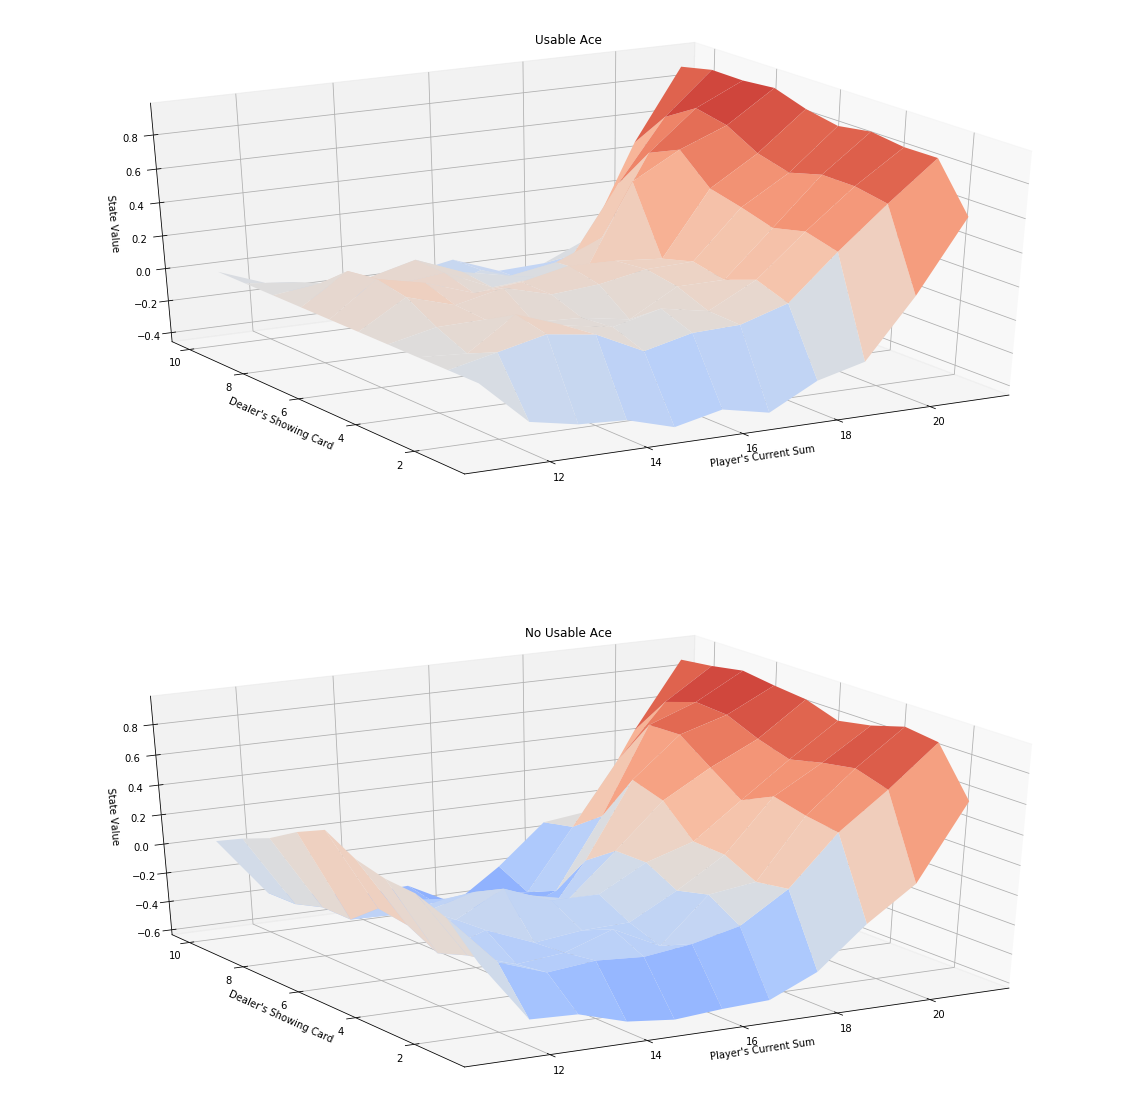

In [20]:
# obtain the state-value function
V_alpha = dict((k,np.max(v)) for k, v in Q_alpha.items())

# plot the state-value function
plot_blackjack_values(V_alpha)

Visualize the policy that is estimated to be optimal.

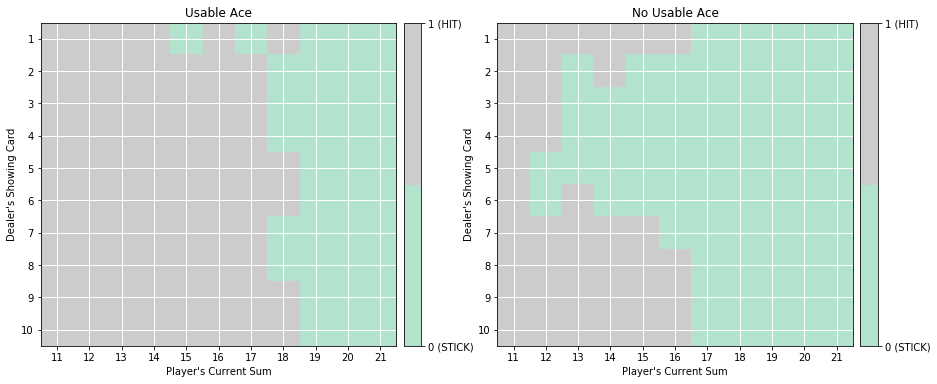

In [21]:
# plot the policy
plot_policy(policy_alpha)